# DSCI 573: Feature and Model Selection

## Lecture 1: Classification evaluation metrics, class imbalance

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar

In [1]:
# Lecture 1
import pickle

import matplotlib.pyplot as plt

# Other
import numpy as np
import pandas as pd

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier
from sklearn import datasets
from sklearn.datasets import (
    fetch_20newsgroups,
    load_digits,
    make_blobs,
    make_hastie_10_2,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.tree import DecisionTreeClassifier
import IPython

from IPython.display import HTML, display


%matplotlib inline

pd.set_option("display.max_colwidth", 200)

## Learning outcomes 

From this lecture, students are expected to be able to:

- Explain why accuracy is not always the best metric in ML.
- Explain components of a confusion matrix. 
- Define precision, recall, and f1-score and use them to evaluate different classifiers. 
- Explain macro-average, weighted average.
- Interpret and use precision-recall curves. 
- Explain average precision score.
- Interpret and use ROC curves and ROC AUC using `scikit-learn`.  
- Identify whether there is class imbalance and whether you need to deal with it.
- Explain and use the following methods to deal with data imbalance.
    - class_weight
    - Undersampling/oversampling (optional)
    - SMOTE (optional)

### Lecture outline

1. Motivation
2. Evaluation metrics for binary classification 
3. Confusion matrix, precision, recall, f-score
4. Precision-recall curve and ROC curve
5. Evaluation metrics for multi-class classification
6. Data imbalance: `class_weight`
7. Summary

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Evaluation metrics for binary classification: Motivation 

### Dataset for demonstration 

- Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.
- For confidentially reasons, it only provides transformed features with PCA, which we'll learn about in DSCI 563.

In [3]:
cc_df = pd.read_csv("data/creditcard.csv", encoding="latin-1")
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


In [4]:
train_df.shape

(199364, 31)

### EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199364 entries, 64454 to 129900
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    199364 non-null  float64
 1   V1      199364 non-null  float64
 2   V2      199364 non-null  float64
 3   V3      199364 non-null  float64
 4   V4      199364 non-null  float64
 5   V5      199364 non-null  float64
 6   V6      199364 non-null  float64
 7   V7      199364 non-null  float64
 8   V8      199364 non-null  float64
 9   V9      199364 non-null  float64
 10  V10     199364 non-null  float64
 11  V11     199364 non-null  float64
 12  V12     199364 non-null  float64
 13  V13     199364 non-null  float64
 14  V14     199364 non-null  float64
 15  V15     199364 non-null  float64
 16  V16     199364 non-null  float64
 17  V17     199364 non-null  float64
 18  V18     199364 non-null  float64
 19  V19     199364 non-null  float64
 20  V20     199364 non-null  float64
 21  V21   

In [6]:
train_df.describe(include="all")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,94888.815669,0.000492,-0.000726,0.000927,0.000630,0.000036,0.000011,-0.001286,-0.002889,-0.000891,...,0.001205,0.000155,-0.000198,0.000113,0.000235,0.000312,-0.000366,0.000227,88.164679,0.001700
std,47491.435489,1.959870,1.645519,1.505335,1.413958,1.361718,1.327188,1.210001,1.214852,1.096927,...,0.748510,0.726634,0.628139,0.605060,0.520857,0.481960,0.401541,0.333139,238.925768,0.041201
min,0.000000,-56.407510,-72.715728,-31.813586,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-8.887017,-44.807735,-2.824849,-10.295397,-2.241620,-22.565679,-11.710896,0.000000,0.000000
25%,54240.000000,-0.918124,-0.600193,-0.892476,-0.847178,-0.691241,-0.768512,-0.553979,-0.209746,-0.642965,...,-0.227836,-0.541795,-0.162330,-0.354604,-0.317761,-0.326730,-0.070929,-0.052819,5.640000,0.000000
50%,84772.500000,0.018854,0.065463,0.179080,-0.019531,-0.056703,-0.275290,0.040497,0.022039,-0.052607,...,-0.029146,0.007666,-0.011678,0.041031,0.016587,-0.052790,0.001239,0.011234,22.000000,0.000000
75%,139349.250000,1.315630,0.803617,1.028023,0.744201,0.610407,0.399827,0.570449,0.327408,0.597326,...,0.186899,0.529210,0.146809,0.439209,0.351366,0.242169,0.090453,0.078052,77.150000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.491217,34.801666,23.917837,44.054461,19.587773,15.594995,...,27.202839,10.503090,22.083545,4.022866,6.070850,3.517346,12.152401,33.847808,11898.090000,1.000000


- We do not have categorical features. All features are numeric. 
- We have to be careful about the `Time` and `Amount` features. 
- We could scale `Amount`. 
- Do we want to scale time?
    - In this lecture we'll do it's probably not the best thing to do. 
    - You'll learn about time series in the second semester. 

Let's separate `X` and `y` for train and test splits.

In [7]:
X_train_big, y_train_big = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]

- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. 
- So let's create a validation set. 
- Our data is large enough so it shouldn't be a problem. 


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_big, 
                                                      y_train_big, 
                                                      test_size=0.3, 
                                                      random_state=123)

### Baseline

In [9]:
dummy = DummyClassifier(strategy="most_frequent")
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

fit_time       0.011085
score_time     0.001033
test_score     0.998302
train_score    0.998302
dtype: float64

### Observations 

- `DummyClassifier` is getting 0.998 validation accuracy!! 
- Should we be happy with this accuracy and deploy this `DummyClassifier` model for fraud detection? 

What's the class distribution? 

In [10]:
train_df["Class"].value_counts(normalize=True)

0    0.9983
1    0.0017
Name: Class, dtype: float64

- We have class imbalance. 
- We have MANY non-fraud transactions and only a handful of fraud transactions. 
- So in the training set, `most_frequent` strategy is labeling 199,025 (99.83%) instances correctly and only 339 (0.17%) instances incorrectly. 
- Is this what we want? 
- The "fraud" class is the important class that we want to spot. 

### Video 2

Let's scale the features and try `LogisticRegression`.   

In [11]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.439085
score_time     0.008658
test_score     0.999176
train_score    0.999249
dtype: float64

- We are getting a slightly better score with logistic regression.  
- What score should be considered an acceptable score here? 
- `.score` by default returns accuracy which is 
$$\frac{\text{correct predictions}}{\text{total examples}}$$
- Is accuracy a good metric here? 
- Is there anything more informative than accuracy that we can use here? 

Let's dig a little deeper.

### Confusion matrix

One way to get a better understanding of the errors is by looking at 
- false positives (type I errors), where the model incorrectly spots examples as fraud
- false negatives (type II errors), where it's missing to spot fraud examples 

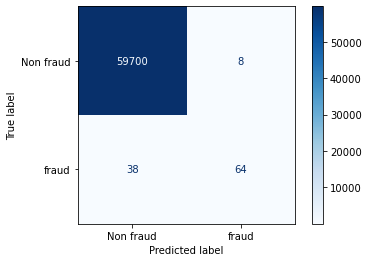

In [12]:
pipe.fit(X_train, y_train)
plot_confusion_matrix(pipe, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);


|   X   | predict negative | predict positive |
|------|----------|-------|
| negative example | True negative (TN) | False positive (FP)|
| positive example | False negative (FN) | True positive (TP) |

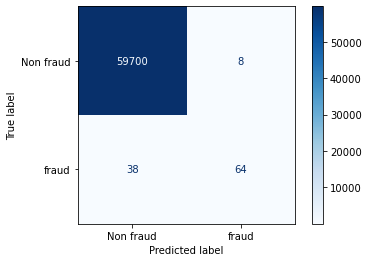

In [13]:
disp = plot_confusion_matrix(pipe, X_valid, y_valid, 
                      display_labels=["Non fraud", "fraud"], 
                      values_format="d", 
                      cmap=plt.cm.Blues);


|   X   | predict negative | predict positive |
|------|----------|-------|
| negative example | True negative (TN) | False positive (FP)|
| positive example | False negative (FN) | True positive (TP) |

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

### What is "positive" and "negative"?

- Two kinds of binary classification problems 
    - Distinguishing between two classes
    - Spotting a class (spot fraud transaction, spot spam, spot disease)
- In case of spotting problems, the thing that we are interested in spotting is considered "positive". 
- Above we wanted to spot fraudulent transactions and so they are "positive". 

You can get a numpy array of confusion matrix as follows: 

In [14]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print("Confusion matrix for fraud data set")
print(disp.confusion_matrix)

Confusion matrix for fraud data set
[[59700     8]
 [   38    64]]


### Confusion matrix with cross-validation 

- You can also calculate confusion matrix with cross-validation using the `cross_val_predict`. 
- But then you cannot conveniently use `plot_confusion_matrix`. 

In [15]:
confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([[139296,     21],
       [    94,    143]])

### Video 3

### Precision, recall, f1 score 

- We have been using `.score` to assess our models, which returns accuracy by default. 
- Accuracy is misleading when we have class imbalance.
- We need other metrics to assess our models.
- We'll discuss three commonly used metrics which are based on confusion matrix: 
    - recall
    - precision
    - f1 score.   
- Note that these metrics will only help us assessing our model.  
- Later we'll talk about a few ways to address class imbalance problem. 

In [16]:
from sklearn.metrics import confusion_matrix
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train,y_train)
predictions = pipe_lr.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print(disp.confusion_matrix)

[[59700     8]
 [   38    64]]


### Recall 

Among all positive examples, how many did you identify?
$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

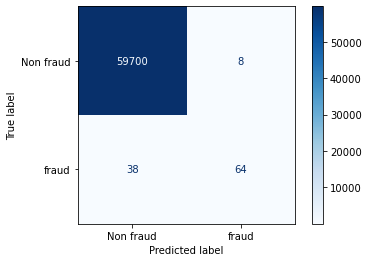

In [17]:
plot_confusion_matrix(pipe, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

In [18]:
print('TP: %0.4f\nFN: %0.4f' %(TP, FN))
recall = TP / (TP + FN)
print("Recall: %0.4f" %(recall))

TP: 64.0000
FN: 38.0000
Recall: 0.6275


### Precision 

Among the positive examples you identified, how many were actually positive?

$$ precision = \frac{TP}{TP+FP}$$

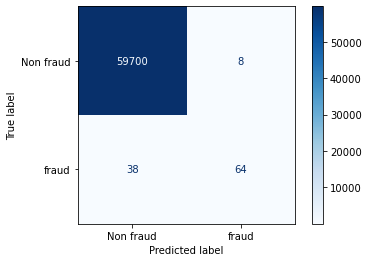

In [19]:
plot_confusion_matrix(pipe, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

In [20]:
print('TP: %0.4f\nFP: %0.4f' %(TP, FP))
precision = TP / (TP + FP)
print("Precision: %0.4f" %(precision))

TP: 64.0000
FP: 8.0000
Precision: 0.8889


### F1-score

- F1-score combines precision and recall to give one score, which could be used in hyperparameter optimization, for instance. 
- F1-score is a harmonic mean of precision and recall. 


$$ f1 = 2 \times \frac{ precision \times recall}{precision + recall}$$


In [21]:
f1_score = (2 * precision * recall) / (precision + recall)
print("f1: %0.4f" %(f1_score))

f1: 0.7356


Let's look at all metrics at once on our dataset.

In [22]:
## Calculate evaluation metrics by ourselves
data = {}
data["accuracy"] = [(TP + TN) / (TN + FP + FN + TP)]
data["error"] = [(FP + FN) / (TN + FP + FN + TP)]
data["precision"] = [precision] # TP / (TP + FP)
data["recall"] = [recall] # TP / (TP + FN)
data["f1 score"] = [f1_score] # (2 * precision * recall) / (precision + recall)
df = pd.DataFrame(data)
df

,accuracy,error,precision,recall,f1 score
0,0.999231,0.000769,0.888889,0.627451,0.735632


- `scikit-learn` has functions for these metrics. See [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1))
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
df = pd.DataFrame(data)
df

,accuracy,error,precision,recall,f1 score
0,0.999231,0.000769,0.888889,0.627451,0.735632
1,0.999231,0.000769,0.888889,0.627451,0.735632


The scores match. 

### Classification report 

- There is a convenient function called `classification_report` in `sklearn` which gives this info. 

In [24]:
pipe_lr.classes_

array([0, 1])

In [25]:
from sklearn.metrics import classification_report

print(
    classification_report(y_valid, pipe_lr.predict(X_valid),
        target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



### Macro average vs weighted average

macro average 
- You give equal importance to all classes and average over all classes.  
- For instance, in the example above, recall for non-fraud is 1.0 and fraud is 0.63, and so macro average is 0.81. 
- More relevant in case of multi-class problems.

weighted average    
- Weighted by the number of samples in each class. 
- Divide by the total number of samples. 

Which one is relevant when depends upon whether you think each class should have the same weight or each sample should have the same weight. 
    

### Interim summary 

- Accuracy is misleading when you have class imbalance. 
- A confusion matrix provides a way to break down errors made by our model. 
- We looked at three metrics based on confusion matrix: 
    - precision, recall, f1-score. 
- Note that what you consider "positive" (fraud in our case) is important when calculating precision, recall, and f1-score. 
- If you flip what is considered positive or negative, we'll end up with different TP, FP, TN, FN, and hence different precision, recall, and f1-scores. 

### Evalution metrics overview  
There is a lot of terminology here. See [terminology document](https://ubc-mds.github.io/resources_pages/terminology/) for more details.

<img src='./imgs/evaluation-metrics.png' width="1000" height="1000" />

### Evaluation metrics for multi-class classification 

Accuracy: 0.962


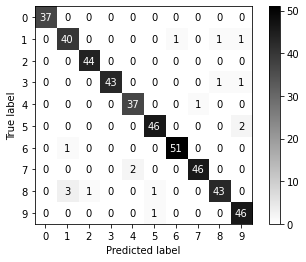

In [26]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

digits = load_digits()
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
    digits.data / 16., digits.target, random_state=0)
lr = LogisticRegression(max_iter=1000).fit(X_train_digits, y_train_digits)
pred = lr.predict(X_test_digits)
print("Accuracy: {:.3f}".format(accuracy_score(y_test_digits, pred)))
plot_confusion_matrix(lr, X_test_digits, y_test_digits, cmap='gray_r');

In [27]:
print(classification_report(y_test_digits, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      1.00      0.99        44
           3       1.00      0.96      0.98        45
           4       0.95      0.97      0.96        38
           5       0.96      0.96      0.96        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.96      0.90      0.92        48
           9       0.92      0.98      0.95        47

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



### Cross validation with different metrics

- We can pass different evaluation metrics with `scoring` argument of `cross_validate`.

In [28]:
scoring=["accuracy", "f1", "recall", "precision"] # scoring can be a string, a list, or a dictionary
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(pipe, X_train_big, y_train_big, 
                        return_train_score=True, scoring=scoring)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.595743,0.032707,0.999147,0.999367,0.711864,0.783726,0.617647,0.675277,0.840000,0.933673
1,0.625880,0.032610,0.999298,0.999329,0.766667,0.770878,0.676471,0.664207,0.884615,0.918367
2,0.591718,0.032535,0.999273,0.999216,0.743363,0.726477,0.617647,0.612546,0.933333,0.892473
3,0.605514,0.031313,0.999172,0.999279,0.697248,0.753747,0.558824,0.649446,0.926829,0.897959
4,0.604924,0.032722,0.999172,0.999223,0.702703,0.731602,0.582090,0.621324,0.886364,0.889474


- You can also create [your own scoring function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and pass it to `cross_validate`. 

#### Questions for class discussion 

- Consider a disease diagnosis system. Suppose you have 100 examples: 20 with disease = 'yes' and 80 with disease = 'no'. 
- High precision system example: Consider a very conservative system that classifies examples as 'yes' only in the presence of certain value for a strong feature. Suppose in your dataset there is only one such example. 
    - Precision = TP/(TP + FP) = 1 / (1 + 0) = 1
    - What's the recall in this case? 
- High recall system example: Consider a system which generously classifies all examples as 'yes'. 
    - Recall = TP/(TP + FN) = 20 / (20 + 0) = 1
    - What's the precision in this case? 

### Video 4

### Precision-recall curve

- What if you care about certain types of errors more than others?
- In the fraud detection example, you want to be conservative and bias the model towards predicting "positive".
- There is a trade-off between precision and recall. 
    - if you identify more things as positive, recall is going to increase but there are likely to be more false positives. 
- We said earlier that `predict` returns 1 when `predict_proba`'s probabilities are above 0.5 for the positive class.

**Key idea: what if we threshold the probability at a different values?**

In [29]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train); 

In [30]:
y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



By default, predictions use the threshold of 0.5. If `predict_proba` > 0.5, predict fraud else predict non-fraud.

In [31]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > .50
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



- In our case, we do not want to miss fraudulent transactions. So we want high recall. 
- What if we decrease the threshold so that we get a bit higher recall; we identify more things as positive.

In [32]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > .30
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.82      0.67      0.74       102

    accuracy                           1.00     59810
   macro avg       0.91      0.83      0.87     59810
weighted avg       1.00      1.00      1.00     59810



- Recall that precision = TP/TP+FP and recall = TP/# positives
- Decreasing the threshold means a lower bar for predicting fraud. 
    - recall would either stay the same or go up and precision is likely to go down
    - occasionally, precision may increase if all the new examples after decreasing the threshold are TPs.  
- Increasing the threshold means a higher bar for predicting fraud. 
    - recall would go down or stay the same but precision is likely to go up 
    - occasionally, precision may go down as the denominator for precision is TP+FP. 
   

Let's sweep through different thresholds. 

In [33]:
thresholds = np.arange(0.0, 1.0, 0.1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [34]:
pr_dict = {"threshold":[], "precision":[], "recall":[], "f1 score":[]}
for threshold in thresholds:
    preds = pipe_lr.predict_proba(X_valid)[:,1] > threshold
    pr_dict['threshold'].append(threshold)
    pr_dict['precision'].append(precision_score(y_valid, preds))
    pr_dict['recall'].append(recall_score(y_valid, preds))
    pr_dict['f1 score'].append(f1_score(y_valid, preds))

In [35]:
pd.DataFrame(pr_dict)

,threshold,precision,recall,f1 score
0,0.0,0.001705,1.000000,0.003405
1,0.1,0.780000,0.764706,0.772277
2,0.2,0.795699,0.725490,0.758974
3,0.3,0.819277,0.666667,0.735135
4,0.4,0.876712,0.627451,0.731429
5,0.5,0.888889,0.627451,0.735632
6,0.6,0.897059,0.598039,0.717647
7,0.7,0.892308,0.568627,0.694611
8,0.8,0.901639,0.539216,0.674847
9,0.9,0.894737,0.500000,0.641509


### Precision-recall curve

A precision-recall curve does this computation for a grid of possible thresholds and shows the results in a plot:

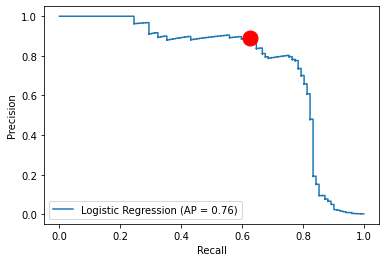

In [36]:
from sklearn.metrics import plot_precision_recall_curve
prc = plot_precision_recall_curve(pipe_lr, X_valid, y_valid, name='Logistic Regression');
plt.plot(recall_score(y_valid, pipe_lr.predict(X_valid)), precision_score(y_valid, pipe_lr.predict(X_valid)), 'or', markersize=15);

- The threshold is not shown here, but it's going from 1 (upper-left) to 0 (lower right).
- The red dot is the threshold 0.5.
- The top-right would be a perfect classifier (precision = recall = 1).

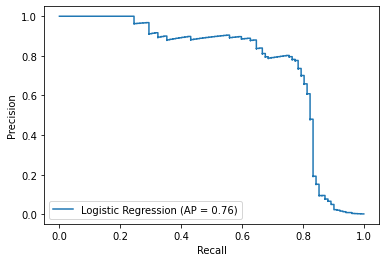

In [37]:
prc.plot();

A few comments on PR curve

- It seems like there might be some good compromises here between precision 0.7 and 0.8.
- In the plot, "AP" is a score that summarizes the "goodness" of the above plot.


### Let's compare `SVC` and `LogisticRegression`  

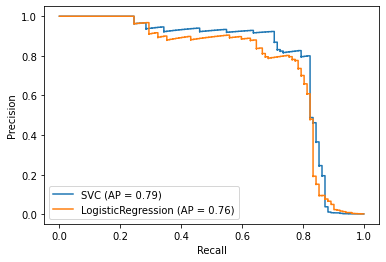

In [38]:
pipe_svc = make_pipeline(StandardScaler(), SVC())
pipe_svc.fit(X_train, y_train)
pr_svc = plot_precision_recall_curve(pipe_svc, X_valid, y_valid, name='SVC')
pr_logistic = plot_precision_recall_curve(pipe_lr, X_valid, y_valid, ax=plt.gca(), name='LogisticRegression')

### AP vs. F1-score

It is very important to note this distinction:

- F1 score is for a given threshold and measures the quality of `predict`.
- AP score is a summary across thresholds and measures the quality of `predict_proba`.


### Receiver Operating Characteristic Curve (ROC Curve)

- [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plots sensitivity (recall) ($\frac{TP}{\#positives}$) against false positive rate ($\frac{FP}{\# negatives }$) 
- Similar to PR curve, it's based on `predict_proba` scores. 
- The diagonal line is what happens if your guesses are random.

In [39]:
cm = confusion_matrix(y_valid, pipe_lr.predict(X_valid))

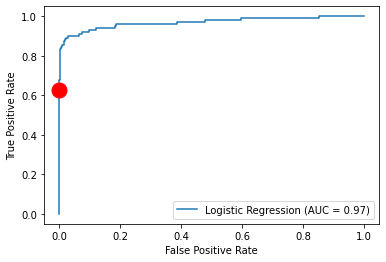

In [40]:
from sklearn.metrics import plot_roc_curve

rc = plot_roc_curve(pipe_lr, X_valid, y_valid, name='Logistic Regression');
plt.plot(cm[0,1]/(cm[0].sum()), cm[1,1]/(cm[1].sum()), 'or', markersize=15);

- The red dot corresponds to the threshold of 0.5, which is used by predict.

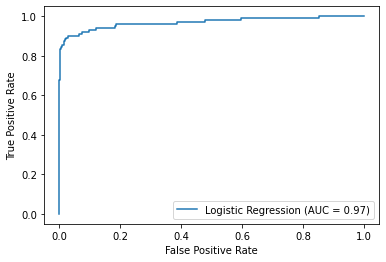

In [41]:
rc.plot();

- Unlike the precision-recall curve, here the top-left is the best.
- Unlike the precision-recall curve, this curve is monotonic.
- AUC provides a single meaningful number for the model performance. 
- AUC of 1.0 means perfect classification and AUC of 0.5 means random chance

Note: there are functions `precision_recall_curve` and `roc_curve` (without the plot_) if you want to raw numbers.

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:,1])

0.9689508549450464

### Let's look at all the scores at once

In [43]:
scoring=["accuracy", "f1", "recall", "precision", 'roc_auc', 'average_precision']
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(pipe, X_train_big, y_train_big, scoring=scoring)
pd.DataFrame(scores).mean()

fit_time                  0.577790
score_time                0.053966
test_accuracy             0.999212
test_f1                   0.724369
test_recall               0.610536
test_precision            0.894228
test_roc_auc              0.967438
test_average_precision    0.744030
dtype: float64

### Extra information 

- If the threshold is 1, we always predict "negative".
    - the true positive rate is 0 because there are no true positives
    - the false positive rate is 0 because there are no false positives
    - this is the bottom-left point in the curve
- If the threshold is 0, we always predict "positive".
    - the true positive rate (recall) is 1 because we have identified all positive examples
    - the false positive rate is 1 because we have falsely identified all negatives as positive
    - this is the upper-right point in the curve

### ROC (optional material)


<img src='./imgs/roc_threshold.gif' width="800" height="800" />

[Source](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

#### Area under the curve animation (optional)


<img src='./imgs/roc_cutoff.gif' width="800" height="800" />

[Source](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

### ROC toy example (optional)
<img src='./imgs/roc_toy_example.png' width="1000" height="1000" />

### True/False questions: decision theory, evaluation metrics

1. In medical diagnosis, false positives are more damaging than false negatives (assume "positive" means the person has a disease, "negative" means they don't).
2. In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means they it's not).
3. In the medical diagnosis, high recall is more important than high precision.
4. If method A gets a higher accuracy than method B, that means its precision is also higher.
5. If method A gets a higher accuracy than method B, that means its recall is also higher.

<br><br><br><br><br><br><br><br><br>

Method A - higher accuracy but lower precision

| Negative | Positive
| -------- |:-------------:|
| 90      | 5|
| 5      | 0|

Method B - lower accuracy but higher precision

| Negative | Positive
| -------- |:-------------:|
| 80      | 15|
| 0      | 5|



- Method A accuracy: 90/100
- Method B accuracy: 85/100
- Method A precision: 0
- Method B precision: 0.25


### Video 5

## Dealing with class imbalance <a name="imb"></a>

### Class imbalance in training sets

- This typically refers to having many more examples of one class than another in one's training set.
- Real world data is often imbalanced. 
    - Our Credit Card Fraud dataset is imbalanced.
    - Ad clicking data is usually drastically imbalanced. (Only around ~0.01% ads are clicked.)
    - Spam classification datasets are also usually imbalanced.

### Addressing class imbalance
A very important question to ask yourself: "Why do I have a class imbalance?"

- Is it because one class is much more rare than the other?
    - If it's just because one is more rare than the other, you need to ask whether you care about one type of error more than the other.    
- Is it because of my data collection methods?
    - If it's the data collection, then that means _your test and training data come from different distributions_!
  
But, if you answer "no" to both question, it may be fine to just ignore the class imbalance.

### Which type of error is more important? 

- False positives (FPs) and false negatives (FNs) have quite different real-world consequences. 
- In PR curve and ROC curve, we saw how changing the prediction threshold can change FPs and FNs. 
- We can then pick the threshold that's appropriate for our problem. 
- Example: if we want high precision, we may use the threshold to 0.80. We'll then predict something as Fraud only when the model is very certain about it. 

In [44]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



In [45]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > .80
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.90      0.54      0.67       102

    accuracy                           1.00     59810
   macro avg       0.95      0.77      0.84     59810
weighted avg       1.00      1.00      1.00     59810



### Handling imbalance

Can we change the model itself rather than changing the threshold so that it takes into account the errors that are important to us?

There are two common approaches for this: 
- **Changing the training procedure** 
    - `class_weight`
- **Changing the data (optional)**
   - Undersampling
   - Oversampling 
       - Random oversampling
       - SMOTE 

### Approach 1:  Changing the training procedure 

- All `sklearn` classifiers have a parameter called `class_weight`.
- This allows you to specify that one class is more important than another.
- For example, maybe a false negative is 10x more problematic than a false positive. 

### Example: `class_weight` parameter of `sklearn LogisticRegression` 
> class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, **class_weight=None**, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

> class_weight: dict or 'balanced', default=None

> Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. 

In [46]:

url = "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"
HTML("<iframe src=%s width=1000 height=650></iframe>" % url)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


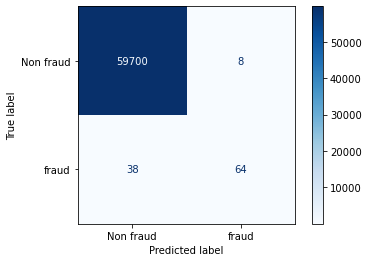

In [47]:
plot_confusion_matrix(pipe_lr, X_valid, y_valid, 
                      display_labels=["Non fraud", "fraud"], 
                      values_format="d", cmap=plt.cm.Blues);

In [48]:
pipe_lr.named_steps['logisticregression'].classes_

array([0, 1])

Let's set fraud a weight of 10.

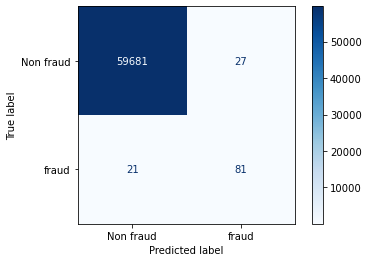

In [49]:
pipe_lr_weight = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, 
                                                                    class_weight={1:10}))
pipe_lr_weight.fit(X_train, y_train)
plot_confusion_matrix(pipe_lr_weight, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

- Notice we've reduced false negatives and predicted more Fraud this time.
- This was equivalent to saying "repeat every positive example 10x in the training set".
- But repeating data would slow down the code, whereas this doesn't.  
- Note that as a consequence we are also increasing false positives.    

### `class_weight="balanced"`
- A useful setting is `class_weight="balanced"`.
- This sets the weights so that the classes are "equal".

> class_weight: dict, ‘balanced’ or None
If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). If a dictionary is given, keys are classes and values are corresponding class weights. If None is given, the class weights will be uniform.

> sklearn.utils.class_weight.compute_class_weight(class_weight, classes, y)

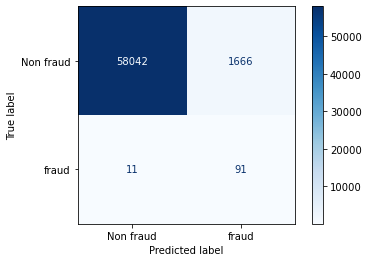

In [50]:
pipe_lr_balanced = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, 
                                                                      class_weight="balanced"))
pipe_lr_balanced.fit(X_train, y_train)
plot_confusion_matrix(pipe_lr_balanced, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

We have reduced false negatives but we have many more false positives now! 

What is "balanced" doing exactly?

In [51]:
print(y_train.value_counts())
ratio = np.bincount(y_train)[0]/ np.bincount(y_train)[1]
print("Ratio: ", ratio)

0    139317
1       237
Name: Class, dtype: int64
Ratio:  587.8354430379746


- We have 587 times more negatives examples, so let's repeat our positive examples so that we have 587x more of them.
- Then the classes are "balanced".

You can also use `compute_class_weight` to calculate class weights. 

In [52]:
from sklearn.utils.class_weight import compute_class_weight
compute_class_weight("balanced", np.unique(y_train), y_train)

array([  0.50085058, 294.41772152])

If we use the above `ratio` in `class_weight`, we'll get similar results to `class_weight="balanced"`

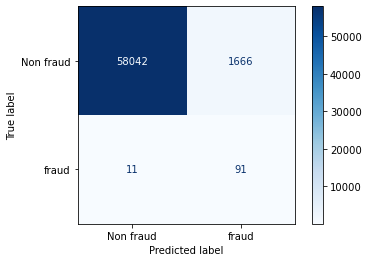

In [53]:
pipe_lr_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, 
                                                                   class_weight={1: ratio}))
pipe_lr_ratio.fit(X_train, y_train)
plot_confusion_matrix(pipe_lr_ratio, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

### Are we doing better with `class_weight="balanced"`?

In [54]:
comp_dict = {}
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
scoring=["accuracy", "f1", "recall", "precision", 'roc_auc', 'average_precision']
orig_scores = cross_validate(pipe_lr, X_train_big, y_train_big, scoring=scoring)

In [55]:
pipe_lr_balanced = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, class_weight="balanced"))
scoring=["accuracy", "f1", "recall", "precision", 'roc_auc', 'average_precision']
bal_scores = cross_validate(pipe_lr_balanced, X_train_big, y_train_big, scoring=scoring)
comp_dict = {"Original":pd.DataFrame(orig_scores).mean().tolist(), 
             "class_weight='balanced'":pd.DataFrame(bal_scores).mean().tolist()}
pd.DataFrame(comp_dict, index = bal_scores.keys())

,Original,class_weight='balanced'
fit_time,0.603426,0.639799
score_time,0.055340,0.061300
test_accuracy,0.999212,0.973626
test_f1,0.724369,0.103831
test_recall,0.610536,0.896883
test_precision,0.894228,0.055119
test_roc_auc,0.967438,0.970881
test_average_precision,0.744030,0.730627


- Recall is much better but precision has dropped a lot; we have many false positives. 
- You could also optimize `class_weight` using hyperparameter optimization for your specific problem. 

- Changing the class weight will **generally reduce accuracy**.
- The original model was trying to maximize accuracy.
- Now you're telling it to do something different.
- But that can be fine, accuracy isn't the only metric that matters.

### Stratified Splits

- A similar idea of "balancing" classes can be applied to data splits.
- We have the same option in `train_test_split` with the `stratify` argument. 
- By default it splits the data so that if we have 10% negative examples in total, then each split will have 10% negative examples.
- If you are carrying out cross validation using `cross_validate`, by default it uses [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). From the documentation: 

> This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

- In other words, if we have 10% negative examples in total, then each fold will have 10% negative examples.


### Is stratifying a good idea? 

  - Well, it's no longer a random sample, which is probably theoretically bad, but not that big of a deal.
  - If you have many examples, it shouldn't matter as much.
  - It can be especially useful in multi-class, say if you have one class with very few cases.
  - In general, these are difficult questions.

### Changing the data (optional)

- Undersampling
- Oversampling 
   - Random oversampling
   - SMOTE 

We cannot use sklearn pipelines because of some API related problems. But there is something called [`imbalance learn`](https://imbalanced-learn.org/stable/), which is an extension of the `scikit-learn` API that allows us to resample. You can install it in your environment with this command: 

`conda install -c conda-forge imbalanced-learn`

### Undersampling

In [56]:
import imblearn
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(
    X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(139554, 30)
(474, 30)
[237 237]


In [57]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), StandardScaler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train, y_train,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores).mean()

fit_time                  0.045597
score_time                0.015923
test_roc_auc              0.968925
test_average_precision    0.368409
dtype: float64

### Oversampling 

- Random oversampling with replacement 
- SMOTE: Synthetic Minority Over-sampling Technique

In [58]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(
    X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(139554, 30)
(278634, 30)
[139317 139317]


In [59]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), StandardScaler(), LogisticRegression(max_iter=1000))
scores = cross_validate(oversample_pipe,
                        X_train, y_train,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores).mean()

fit_time                  2.166839
score_time                0.019708
test_roc_auc              0.960806
test_average_precision    0.717245
dtype: float64

#### [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/pdf/1106.1813.pdf)

[sklearn SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)

- Create "synthetic" examples rather than by over-sampling with replacement.
- Inspired by a technique of data augmentation that proved successful in handwritten character recognition. 
- The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the $k$ minority class nearest neighbors.
- $k$ is chosen depending upon the amount of over-sampling required.

#### SMOTE idea 

- Take the difference between the feature vector (sample) under consideration and its nearest neighbor. 
- Multiply this difference by a random number between 0 and 1, and add it to the feature vector under consideration. 
- This causes the selection of a random point along the line segment between two specific features. 
- This approach effectively forces the decision region of the minority class to become more general.

<img src="imgs/SMOTE_doccam.png" width="600" height="600">

### Using SMOTE

- You need to install [`imbalanced-learn`](https://imbalanced-learn.readthedocs.io/en/stable/install.html)
> class imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)

> Class to perform over-sampling using SMOTE.

> This object is an implementation of SMOTE - Synthetic Minority Over-sampling Technique as presented in [this paper](https://arxiv.org/pdf/1106.1813.pdf).

In [60]:
from imblearn.over_sampling import SMOTE

smote_pipe = make_imb_pipeline(SMOTE(), StandardScaler(), LogisticRegression(max_iter=1000))
scores = cross_validate(smote_pipe, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores).mean()

fit_time                  3.187088
score_time                0.011975
test_roc_auc              0.967885
test_average_precision    0.741769
dtype: float64

- We got higher average precision score with SMOTE in this case. 

#### Summary

- A number of possible ways to evaluate machine learning models 
    - Choose the evaluation metric that makes most sense in your context or which is most common in your discipline  
- Two kinds of binary classification problems 
    - Distinguishing between two classes (e.g., dogs vs. cats)
    - Spotting a class (e.g., spot fraud transaction, spot spam)
- Precision, recall, f1-score are useful when dealing with spotting problems. 
- The thing that we are interested in spotting is considered "positive".   
- Do you need to deal with class imbalance in the given problem? 
- Methods to deal with class imbalance 
    - Changing the training procedure 
        - `class_weight`
    - Changing the data 
        - undersampling
        - oversampling, SMOTE (creating synthetic examples)       

### Relevant papers and resources 

- [The Relationship Between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)
- [Article claiming that PR curve are better than ROC for imbalanced datasets](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)
- [Precision-Recall-Gain Curves: PR Analysis Done Right](https://papers.nips.cc/paper/2015/file/33e8075e9970de0cfea955afd4644bb2-Paper.pdf)
- [ROC animation](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)
- [Generalization in Adaptive Data Analysis and Holdout Reuse](https://arxiv.org/pdf/1506.02629.pdf)